In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.predict import load_model


from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio, mean_squared_error
import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import yaml
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.4f}".format

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [5]:
def standardize(X: torch.tensor):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

def get_metrics(tomo_path, gt_tomo_path):
    
    n2v_psnr, n2v_ssim_idx = None, None
    
    if (tomo_path is not None) and (gt_tomo_path is not None):       
        try:
            name = tomo_path.split('/')[-1].replace('.mrc', '_n2vDenoised.mrc')
            gt_data = read_array(gt_tomo_path)
            gt_data = torch.tensor(gt_data).unsqueeze(0).unsqueeze(0)
            gt_data = standardize(clip(gt_data))


            n2v_pred_path = os.path.join(PARENT_PATH, "data/S2SDenoising/denoised/%s" % (name))
            n2v_data = read_array(n2v_pred_path)
            n2v_data = torch.tensor(n2v_data).unsqueeze(0).unsqueeze(0)
            n2v_data = standardize(clip(n2v_data))
            n2v_psnr, n2v_ssim_idx = float(peak_signal_noise_ratio(n2v_data, gt_data)), float(ssim(n2v_data, gt_data))
            
            
        except OSError:
            pass

        
    return n2v_psnr, n2v_ssim_idx


def logdir_to_dataframe(logdir):
    data_log = []
    keys = ['Version_comment', 'transform', 'full_tomo_psnr', 'full_tomo_ssim', 'baseline_psnr', 'baseline_ssim',
            'tomo_path', 'gt_tomo_path']
    
    all_logs = glob(logdir+'*/*.yaml')
    
    for yaml_logdir in all_logs:
        model = yaml_logdir.split('/')[-3]
        version = yaml_logdir.split('/')[-2]
        with open(yaml_logdir) as f:
            hparams = yaml.load(f, Loader=yaml.BaseLoader)
        # yaml is stupid
        with open(yaml_logdir) as f:
            s = f.readlines()
            try:
                dataloader = [x for x in s if 'Dataloader' in x][0]
                dataloader = dataloader.split('.')[-1].replace('\n', '').replace('\'', '')
            except:
                dataloader = 'Unknown'

        row_vals = [model, version, dataloader, hparams['loss_fn']['alpha']]
        for k in keys:
            try:
                row_vals += [hparams[k]]
            except KeyError:
                row_vals += [None]
        data_log.append(row_vals)

    data_log = pd.DataFrame(data_log, columns=['model', 'version', 'dataloader', 'TV_alpha']+keys)
    data_log = data_log.sort_values(['model', 'version'])

    baseline_metrics = data_log[['tomo_path', 'gt_tomo_path']].apply(lambda x: get_metrics(x[0], x[1]), axis=1)

    data_log['n2v_psnr'], data_log['n2v_ssim'] = zip(*baseline_metrics) 
    data_log[['full_tomo_psnr', 'full_tomo_ssim']] = data_log[['full_tomo_psnr', 'full_tomo_ssim']].astype(float)
    data_log[['baseline_psnr', 'baseline_ssim']] = data_log[['baseline_psnr', 'baseline_ssim']].astype(float)

    tomo_path = data_log.tomo_path.map(lambda x: x.split('/')[-1] if x is not None else x)
    gt_tomo_path = data_log.gt_tomo_path.map(lambda x: x.split('/')[-1] if x is not None else x)

    data_log.drop(['tomo_path', 'gt_tomo_path'], axis=1, inplace=True)
    data_log['tomo_path'], data_log['gt_tomo_path'] = [tomo_path, gt_tomo_path]
    
    _vals = 100*data_log[['full_tomo_ssim', 'n2v_ssim']].apply(lambda x: (x-data_log['baseline_ssim'])/data_log['baseline_ssim'])
    data_log['ssim_vs_baseline'], data_log['n2v_ssim_vs_baseline'] = zip(*_vals.values)

    _vals = 100*data_log[['full_tomo_psnr', 'n2v_psnr']].apply(lambda x: (x-data_log['baseline_psnr'])/data_log['baseline_psnr'])
    data_log['psnr_vs_baseline'], data_log['n2v_psnr_vs_baseline'] = zip(*_vals.values)
    
    return data_log

# Model 9

## Epoch comparison

In [17]:
logdir = 'data/S2SDenoising/tryout_model_logs/model9/epoch_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)

data_log

,model,version,dataloader,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,n2v_psnr,n2v_ssim,tomo_path,gt_tomo_path,s2s_ssim_vs_baseline,n2s_ssim_vs_baseline,s2s_psnr_vs_baseline,n2s_psnr_vs_baseline
1,epoch_comparison,version_0,singleCET_dataset,0,null,{'p': '0.5'},26.7256,0.9972,19.7601,0.9902,24.6583,0.9968,tomoPhantom_model9_Poisson5000+Gauss5.mrc,tomoPhantom_model9.mrc,0.7023,0.6629,35.2505,24.7887
2,epoch_comparison,version_1,singleCET_FourierDataset,0,null,{'p': '0.5'},24.7892,0.9957,19.7601,0.9902,24.6583,0.9968,tomoPhantom_model9_Poisson5000+Gauss5.mrc,tomoPhantom_model9.mrc,0.5545,0.6629,25.4510,24.7887
7,epoch_comparison,version_2,singleCET_ProjectedDataset,0,null,{'p': '0.5'},25.6827,0.9963,19.7601,0.9902,24.6583,0.9968,tomoPhantom_model9_Poisson5000+Gauss5.mrc,tomoPhantom_model9.mrc,0.6122,0.6629,29.9728,24.7887
5,epoch_comparison,version_3,singleCET_ProjectedDataset,0,null,{'p': '0.5'},23.1746,0.9920,19.7601,0.9902,24.6583,0.9968,tomoPhantom_model9_Poisson5000+Gauss5.mrc,tomoPhantom_model9.mrc,0.1804,0.6629,17.2798,24.7887
4,epoch_comparison,version_4,singleCET_dataset,0,null,{'p': '0.5'},27.0522,0.9975,19.7601,0.9902,24.6583,0.9968,tomoPhantom_model9_Poisson5000+Gauss5.mrc,tomoPhantom_model9.mrc,0.7341,0.6629,36.9033,24.7887
6,epoch_comparison,version_5,singleCET_FourierDataset,0,null,{'p': '0.5'},24.6350,0.9963,19.7601,0.9902,24.6583,0.9968,tomoPhantom_model9_Poisson5000+Gauss5.mrc,tomoPhantom_model9.mrc,0.6138,0.6629,24.6708,24.7887
0,epoch_comparison,version_6,singleCET_ProjectedDataset,0,null,{'p': '0.5'},24.1045,0.9940,19.7601,0.9902,24.6583,0.9968,tomoPhantom_model9_Poisson5000+Gauss5.mrc,tomoPhantom_model9.mrc,0.3770,0.6629,21.9859,24.7887
3,epoch_comparison,version_7,singleCET_ProjectedDataset,0,null,{'p': '0.5'},26.4035,0.9971,19.7601,0.9902,24.6583,0.9968,tomoPhantom_model9_Poisson5000+Gauss5.mrc,tomoPhantom_model9.mrc,0.6898,0.6629,33.6205,24.7887


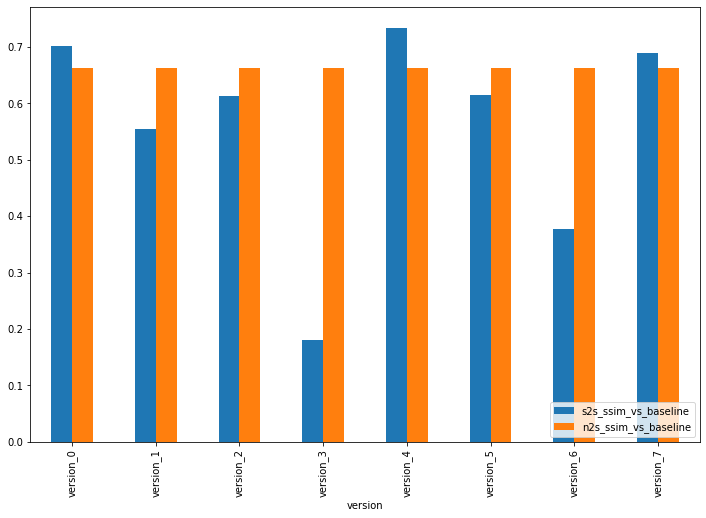

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 's2s_ssim_vs_baseline', 'n2s_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 's2s_psnr_vs_baseline', 'n2s_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

# Model 14

## Epoch comparison

In [20]:
logdir = 'data/S2SDenoising/tryout_model_logs/model14/epoch_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)

data_log

,model,version,dataloader,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,n2v_psnr,n2v_ssim,tomo_path,gt_tomo_path,s2s_ssim_vs_baseline,n2s_ssim_vs_baseline,s2s_psnr_vs_baseline,n2s_psnr_vs_baseline
1,epoch_comparison,version_0,singleCET_dataset,0,null,{'p': '0.5'},17.8846,0.9753,15.5671,0.9731,18.8049,0.9911,tomoPhantom_model14_Poisson5000+Gauss5+stripes...,tomoPhantom_model14.mrc,0.2321,1.8555,14.8872,20.7989
2,epoch_comparison,version_1,singleCET_FourierDataset,0,null,{'p': '0.5'},17.6393,0.9760,15.5671,0.9731,18.8049,0.9911,tomoPhantom_model14_Poisson5000+Gauss5+stripes...,tomoPhantom_model14.mrc,0.3000,1.8555,13.3118,20.7989
7,epoch_comparison,version_2,singleCET_ProjectedDataset,0,null,{'p': '0.5'},20.2678,0.9844,15.5671,0.9731,18.8049,0.9911,tomoPhantom_model14_Poisson5000+Gauss5+stripes...,tomoPhantom_model14.mrc,1.1667,1.8555,30.1962,20.7989
5,epoch_comparison,version_3,singleCET_ProjectedDataset,0,null,{'p': '0.5'},22.9860,0.9916,15.5671,0.9731,18.8049,0.9911,tomoPhantom_model14_Poisson5000+Gauss5+stripes...,tomoPhantom_model14.mrc,1.9050,1.8555,47.6577,20.7989
4,epoch_comparison,version_4,singleCET_dataset,0,null,{'p': '0.5'},19.3728,0.9815,15.5671,0.9731,18.8049,0.9911,tomoPhantom_model14_Poisson5000+Gauss5+stripes...,tomoPhantom_model14.mrc,0.8655,1.8555,24.4470,20.7989
6,epoch_comparison,version_5,singleCET_FourierDataset,0,null,{'p': '0.5'},19.2360,0.9837,15.5671,0.9731,18.8049,0.9911,tomoPhantom_model14_Poisson5000+Gauss5+stripes...,tomoPhantom_model14.mrc,1.0922,1.8555,23.5682,20.7989
0,epoch_comparison,version_6,singleCET_ProjectedDataset,0,null,{'p': '0.5'},20.9106,0.9869,15.5671,0.9731,18.8049,0.9911,tomoPhantom_model14_Poisson5000+Gauss5+stripes...,tomoPhantom_model14.mrc,1.4217,1.8555,34.3259,20.7989
3,epoch_comparison,version_7,singleCET_ProjectedDataset,0,null,{'p': '0.5'},21.8586,0.9906,15.5671,0.9731,18.8049,0.9911,tomoPhantom_model14_Poisson5000+Gauss5+stripes...,tomoPhantom_model14.mrc,1.7985,1.8555,40.4154,20.7989


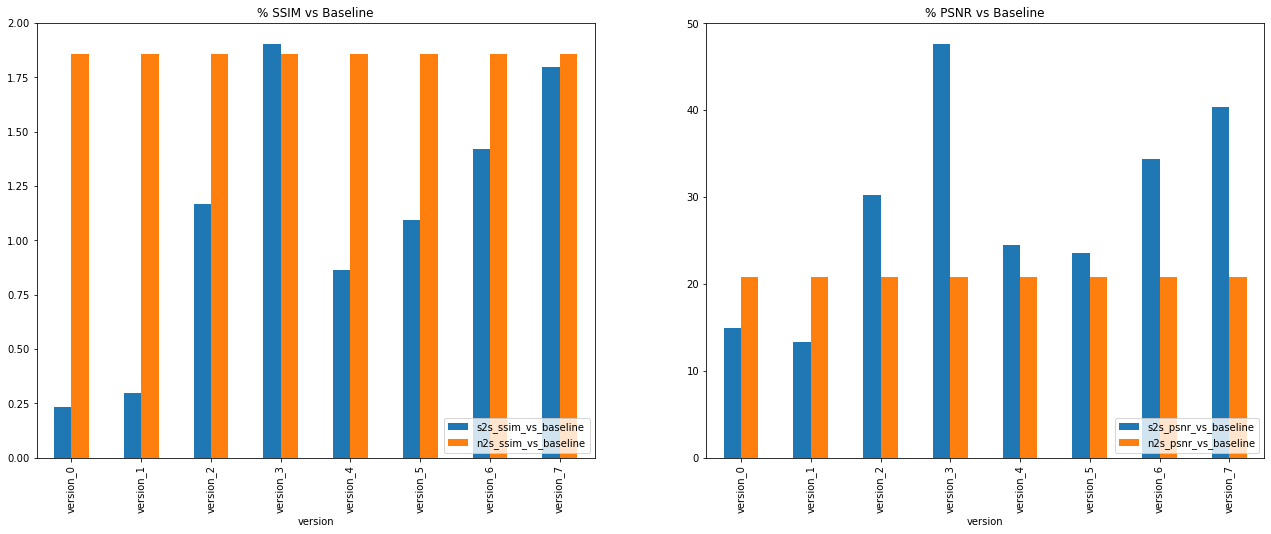

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 's2s_ssim_vs_baseline', 'n2s_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 's2s_psnr_vs_baseline', 'n2s_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

# Tomo02 Dummy

## Denoising comparison

In [6]:
logdir = 'data/S2SDenoising/tryout_model_logs/tomo02_dummy/rawTomo_denoising_comparison/'
logdir = os.path.join(PARENT_PATH, logdir)

data_log = logdir_to_dataframe(logdir)

data_log

,model,version,dataloader,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,n2v_psnr,n2v_ssim,tomo_path,gt_tomo_path,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,rawTomo_denoising_comparison,version_0,singleCET_dataset,0,null,{'p': '0.5'},16.5947,0.9675,14.6098,0.9642,14.6070,0.9646,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,0.3401,0.0442,13.5861,-0.0188
1,rawTomo_denoising_comparison,version_1,singleCET_FourierDataset,0,null,{'p': '0.5'},NaN,NaN,NaN,NaN,14.6070,0.9646,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,NaN,NaN,NaN,NaN
3,rawTomo_denoising_comparison,version_2,singleCET_ProjectedDataset,0,null,{'p': '0.5'},16.6867,0.9714,14.6098,0.9642,14.6070,0.9646,tomo02_dummy.mrc,tomo02_cryoCAREDummy.mrc,0.7459,0.0442,14.2161,-0.0188
2,rawTomo_denoising_comparison,version_3,Unknown,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN


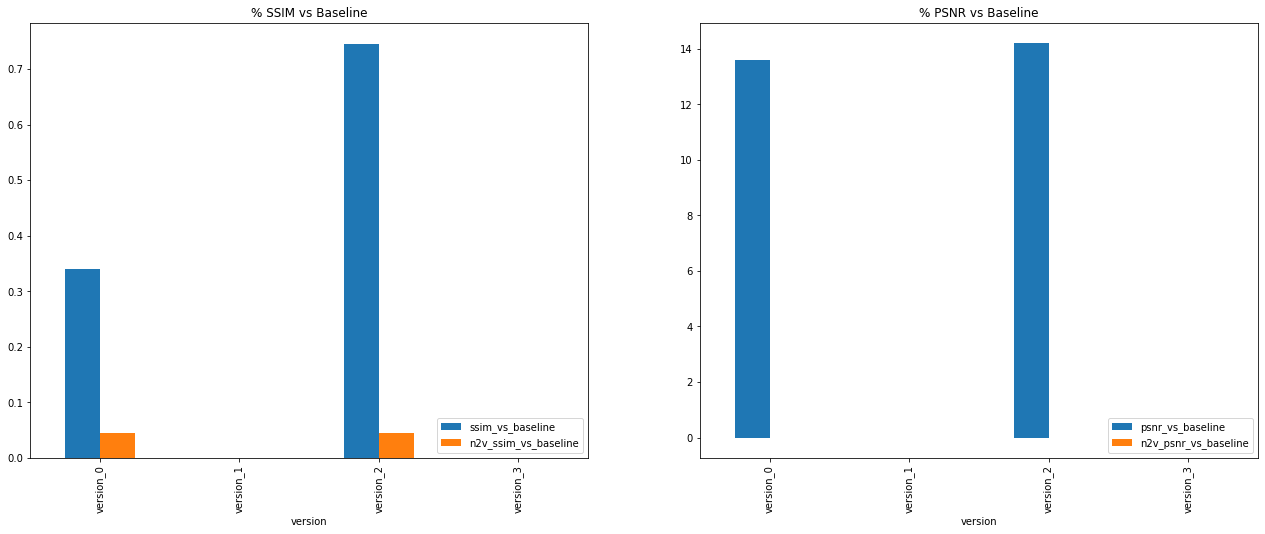

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')